# Hypothese 4

## Hypothese 4.1 -- pre post Oversampling

### 3 Fold

Unique classes in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Number of classes: 5
Train classes: [0 1 2 3 4]
Valid classes: [0 1 2 3 4]
Test classes: [0 1 2 3 4]
Original Training Set: (13275, 22)
Oversampled Training Set: (15335, 22)
Class distribution after oversampling: [3067 3067 3067 3067 3067]
Final Training Set: (15335, 22), Validation Set: (2845, 22), Test Set: (2845, 22)
Teste 180 Parameterkombinationen
Using num_classes = 5 for XGBoost
Starte Native XGBoost Grid Search...
[  1/180] max_depth= 3, lr=0.100, subsample=1.0 → F1: 0.3570±0.008
[  2/180] max_depth= 3, lr=0.100, subsample=0.9 → F1: 0.3575±0.007
[  3/180] max_depth= 3, lr=0.100, subsample=0.8 → F1: 0.3574±0.007
[  4/180] max_depth= 3, lr=0.100, subsample=0.7 → F1: 0.3579±0.010
[  5/180] max_depth= 3, lr=0.100, subsample=0.6 → F1: 0.3592±0.006
[  6/180] max_depth= 3, lr=0.100, subsample=0.5 → F1: 0.3603±0.006
[  7/180] max_depth= 3, lr=0.070, subsample=1.0 → F1: 0.3443±0.009
[  8/180] max_d

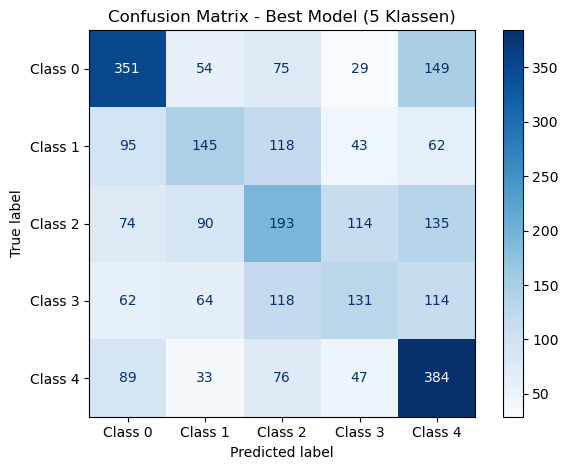


Top 10 Konfigurationen:
F1: 0.5076±0.003 | max_depth=15, lr=0.070, subsample=0.8
F1: 0.5072±0.006 | max_depth=15, lr=0.100, subsample=0.9
F1: 0.5067±0.001 | max_depth=15, lr=0.100, subsample=0.8
F1: 0.5067±0.001 | max_depth=15, lr=0.030, subsample=0.8
F1: 0.5066±0.002 | max_depth=15, lr=0.050, subsample=0.9
F1: 0.5058±0.005 | max_depth=15, lr=0.050, subsample=0.8
F1: 0.5058±0.007 | max_depth=15, lr=0.070, subsample=0.7
F1: 0.5050±0.006 | max_depth=15, lr=0.030, subsample=0.7
F1: 0.5048±0.003 | max_depth=15, lr=0.070, subsample=0.9
F1: 0.5045±0.002 | max_depth=11, lr=0.070, subsample=0.8

Klassen-Verteilung im Test Set:
Klasse 0: 658 Samples
Klasse 1: 463 Samples
Klasse 2: 606 Samples
Klasse 3: 489 Samples
Klasse 4: 629 Samples


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

# Daten laden
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

# Features & Labels trennen (direkt 5 Klassen verwenden)
X = df.drop(columns=['AdoptionSpeed'])
y = df['AdoptionSpeed'].astype(int)

# Check the actual classes in your data
print(f"Unique classes in data: {sorted(np.unique(y))}")
print(f"Number of classes: {len(np.unique(y))}")

# Stratified Split: Train / Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Stratified Split: Temp → Valid / Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train classes:", np.unique(y_train))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# Kategorische Variablen in Kategorie-Typ umwandeln
for df_ in [X_train, X_valid, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# Oversampling nur auf Train
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape}")
print(f"Oversampled Training Set: {X_train_res.shape}")
print(f"Class distribution after oversampling: {np.bincount(y_train_res)}")

# Kategorische Spalten encodieren
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    X_test[cat_cols] = oe.transform(X_test[cat_cols])

print(f"Final Training Set: {X_train_res.shape}, Validation Set: {X_valid.shape}, Test Set: {X_test.shape}")

# HYPOTHESE 4: max_depth × learning_rate × subsample
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 15],
    'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01], 
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
}

total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

def evaluate_params_native(max_depth, learning_rate, subsample, X_train, y_train, num_classes):
    """Evaluiert Parameter mit nativem XGBoost (ohne sklearn)"""
    
    # Manual 5-Fold Cross Validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_tr, label=y_tr)
        dval_fold = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softmax',
            'num_class': num_classes,  # Use actual number of classes
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'random_state': 42,
            'verbosity': 0
        }
        
        # Train model
        model = xgb.train(params, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        # Predict and calculate F1
        y_pred = model.predict(dval_fold)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }

# Kombiniere Training + Validation für Cross-Validation
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

# Determine the actual number of classes
num_classes = len(np.unique(y))
print(f"Using num_classes = {num_classes} for XGBoost")

print("Starte Native XGBoost Grid Search...")
start_time = time.time()

results = []
for i, (max_depth, learning_rate, subsample) in enumerate(
    product(param_grid['max_depth'], 
            param_grid['learning_rate'], 
            param_grid['subsample']), 1):
    
    print(f"[{i:3d}/{total_combinations}] max_depth={max_depth:2d}, lr={learning_rate:.3f}, subsample={subsample:.1f}", end=" ")
    
    result = evaluate_params_native(max_depth, learning_rate, subsample, X_train_val, y_train_val, num_classes)
    results.append(result)
    
    print(f"→ F1: {result['f1_mean']:.4f}±{result['f1_std']:.3f}")

total_time = time.time() - start_time

# Ergebnisse analysieren
results_df = pd.DataFrame(results)

print(f"\nNative XGBoost Grid Search abgeschlossen in {total_time/60:.1f} Minuten")

# Beste Konfiguration finden
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print(f"Best parameters: {{'max_depth': {best_result['max_depth']}, 'learning_rate': {best_result['learning_rate']:.3f}, 'subsample': {best_result['subsample']:.1f}}}")
print(f"Best CV score: {best_result['f1_mean']:.4f}")

# Bestes Modell auf Test Set evaluieren (native XGBoost)
dtrain_final = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'multi:softmax',
    'num_class': num_classes,  # FIXED: Use actual number of classes, not hardcoded 3
    'eval_metric': 'mlogloss',
    'max_depth': int(best_result['max_depth']),
    'learning_rate': best_result['learning_rate'],
    'subsample': best_result['subsample'],
    'random_state': 42,
    'verbosity': 0
}

best_model = xgb.train(best_params, dtrain_final, num_boost_round=100, verbose_eval=False)
y_test_pred = best_model.predict(dtest)

# Test Metriken
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (für alle Klassen)
unique_classes = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_test_pred, labels=unique_classes)

# Create appropriate labels based on your actual classes
if num_classes == 5:
    class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]
elif num_classes == 3:
    class_labels = ["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"]
else:
    class_labels = [f"Class {i}" for i in unique_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Best Model ({num_classes} Klassen)")
plt.tight_layout()
plt.show()

# Top 10 Konfigurationen
print(f"\nTop 10 Konfigurationen:")
print("="*90)
top_10 = results_df.nlargest(10, 'f1_mean')

for idx, row in top_10.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"max_depth={int(row['max_depth']):2d}, lr={row['learning_rate']:.3f}, subsample={row['subsample']:.1f}")

# Klassen-Verteilung anzeigen
print(f"\nKlassen-Verteilung im Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Klasse {cls}: {count} Samples")

## Hypothese 4.2 -- post Oversampling

### 3 Fold

Lade vorverarbeitete Daten...
Training Set (oversampled): (8814, 21)
Validation Set: (2845, 21)
Test Set: (2845, 21)
Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Class distribution in training: [2938 2938 2938]
Teste 180 Parameterkombinationen
Starte Native XGBoost Grid Search...
[  1/180] max_depth= 3, lr=0.100, subsample=1.0 → F1: 0.4734±0.007
[  2/180] max_depth= 3, lr=0.100, subsample=0.9 → F1: 0.4758±0.003
[  3/180] max_depth= 3, lr=0.100, subsample=0.8 → F1: 0.4767±0.006
[  4/180] max_depth= 3, lr=0.100, subsample=0.7 → F1: 0.4792±0.004
[  5/180] max_depth= 3, lr=0.100, subsample=0.6 → F1: 0.4804±0.005
[  6/180] max_depth= 3, lr=0.100, subsample=0.5 → F1: 0.4790±0.003
[  7/180] max_depth= 3, lr=0.070, subsample=1.0 → F1: 0.4693±0.009
[  8/180] max_depth= 3, lr=0.070, subsample=0.9 → F1: 0.4716±0.007
[  9/180] max_depth= 3, lr=0.070, subsample=0.8 → F1: 0.4745±0.008
[ 10/180] max_depth= 3, lr=0.070, subsample=0.7 → F1: 0.4767±0.003
[ 11/180] max_depth= 3, lr

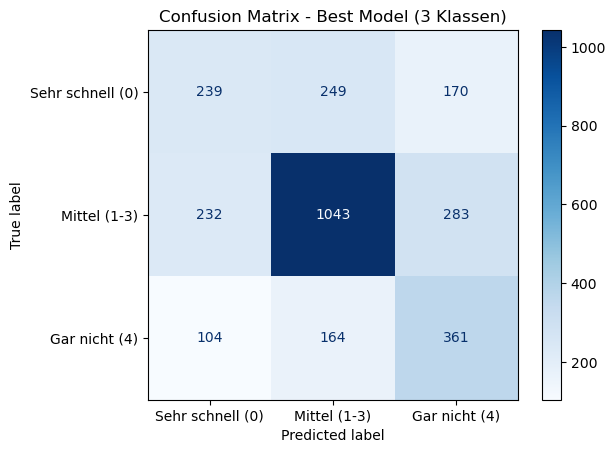


Top 10 Konfigurationen:
F1: 0.5243±0.006 | max_depth=11, lr=0.070, subsample=0.8
F1: 0.5234±0.006 | max_depth=11, lr=0.050, subsample=0.7
F1: 0.5232±0.006 | max_depth= 9, lr=0.070, subsample=0.9
F1: 0.5231±0.004 | max_depth=15, lr=0.030, subsample=0.6
F1: 0.5231±0.003 | max_depth= 9, lr=0.070, subsample=0.5
F1: 0.5230±0.004 | max_depth=15, lr=0.030, subsample=0.8
F1: 0.5229±0.003 | max_depth=11, lr=0.050, subsample=0.5
F1: 0.5229±0.004 | max_depth=11, lr=0.070, subsample=0.7
F1: 0.5228±0.001 | max_depth=15, lr=0.050, subsample=0.5
F1: 0.5228±0.004 | max_depth=11, lr=0.070, subsample=0.5

Klassen-Verteilung im Test Set:
Klasse 0 (Sehr schnell (0)): 658 Samples
Klasse 1 (Mittel (1-3)): 1558 Samples
Klasse 2 (Gar nicht (4)): 629 Samples


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

# Daten laden (bereits preprocessed)
print("Lade vorverarbeitete Daten...")

X_train_res = pd.read_csv("Data/preprocessed/X_train_res.csv")
y_train_res = pd.read_csv("Data/preprocessed/y_train_res.csv").iloc[:, 0]

X_valid = pd.read_csv("Data/preprocessed/X_valid_enc.csv")
y_valid = pd.read_csv("Data/preprocessed/y_valid.csv").iloc[:, 0]

X_test = pd.read_csv("Data/preprocessed/X_test_enc.csv")
y_test = pd.read_csv("Data/preprocessed/y_test.csv").iloc[:, 0]

print(f"Training Set (oversampled): {X_train_res.shape}")
print(f"Validation Set: {X_valid.shape}")
print(f"Test Set: {X_test.shape}")

print("Train classes:", np.unique(y_train_res))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))
print(f"Class distribution in training: {np.bincount(y_train_res)}")

# HYPOTHESE 4: max_depth × learning_rate × subsample
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 15],
    'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01], 
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
}

total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

def evaluate_params_native(max_depth, learning_rate, subsample, X_train, y_train):
    """Evaluiert Parameter mit nativem XGBoost (ohne sklearn)"""
    
    # Manual 3-Fold Cross Validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_tr, label=y_tr)
        dval_fold = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'random_state': 42,
            'verbosity': 0
        }
        
        # Train model
        model = xgb.train(params, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        # Predict and calculate F1
        y_pred = model.predict(dval_fold)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }

# Kombiniere Training + Validation für Cross-Validation
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

print("Starte Native XGBoost Grid Search...")
start_time = time.time()

results = []
for i, (max_depth, learning_rate, subsample) in enumerate(
    product(param_grid['max_depth'], 
            param_grid['learning_rate'], 
            param_grid['subsample']), 1):
    
    print(f"[{i:3d}/{total_combinations}] max_depth={max_depth:2d}, lr={learning_rate:.3f}, subsample={subsample:.1f}", end=" ")
    
    result = evaluate_params_native(max_depth, learning_rate, subsample, X_train_val, y_train_val)
    results.append(result)
    
    print(f"→ F1: {result['f1_mean']:.4f}±{result['f1_std']:.3f}")

total_time = time.time() - start_time

# Ergebnisse analysieren
results_df = pd.DataFrame(results)

print(f"\nNative XGBoost Grid Search abgeschlossen in {total_time/60:.1f} Minuten")

# Beste Konfiguration finden
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print(f"Best parameters: {{'max_depth': {best_result['max_depth']}, 'learning_rate': {best_result['learning_rate']:.3f}, 'subsample': {best_result['subsample']:.1f}}}")
print(f"Best CV score: {best_result['f1_mean']:.4f}")

# Bestes Modell auf Test Set evaluieren (native XGBoost)
dtrain_final = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'max_depth': int(best_result['max_depth']),
    'learning_rate': best_result['learning_rate'],
    'subsample': best_result['subsample'],
    'random_state': 42,
    'verbosity': 0
}

best_model = xgb.train(best_params, dtrain_final, num_boost_round=100, verbose_eval=False)
y_test_pred = best_model.predict(dtest)

# Test Metriken
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (für 3 Klassen)
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_test_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Model (3 Klassen)")
plt.show()

# Top 10 Konfigurationen
print(f"\nTop 10 Konfigurationen:")
print("="*90)
top_10 = results_df.nlargest(10, 'f1_mean')

for idx, row in top_10.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"max_depth={int(row['max_depth']):2d}, lr={row['learning_rate']:.3f}, subsample={row['subsample']:.1f}")

# Klassen-Verteilung anzeigen
print(f"\nKlassen-Verteilung im Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    class_names = ["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"]
    print(f"Klasse {cls} ({class_names[cls]}): {count} Samples")

### 5 Fold

Lade vorverarbeitete Daten...
Training Set (oversampled): (8814, 21)
Validation Set: (2845, 21)
Test Set: (2845, 21)
Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Class distribution in training: [2938 2938 2938]
Teste 180 Parameterkombinationen
Starte Native XGBoost Grid Search...
[  1/180] max_depth= 3, lr=0.100, subsample=1.0 → F1: 0.4763±0.015
[  2/180] max_depth= 3, lr=0.100, subsample=0.9 → F1: 0.4786±0.013
[  3/180] max_depth= 3, lr=0.100, subsample=0.8 → F1: 0.4776±0.007
[  4/180] max_depth= 3, lr=0.100, subsample=0.7 → F1: 0.4820±0.009
[  5/180] max_depth= 3, lr=0.100, subsample=0.6 → F1: 0.4823±0.006
[  6/180] max_depth= 3, lr=0.100, subsample=0.5 → F1: 0.4811±0.009
[  7/180] max_depth= 3, lr=0.070, subsample=1.0 → F1: 0.4702±0.010
[  8/180] max_depth= 3, lr=0.070, subsample=0.9 → F1: 0.4741±0.011
[  9/180] max_depth= 3, lr=0.070, subsample=0.8 → F1: 0.4775±0.009
[ 10/180] max_depth= 3, lr=0.070, subsample=0.7 → F1: 0.4758±0.006
[ 11/180] max_depth= 3, lr

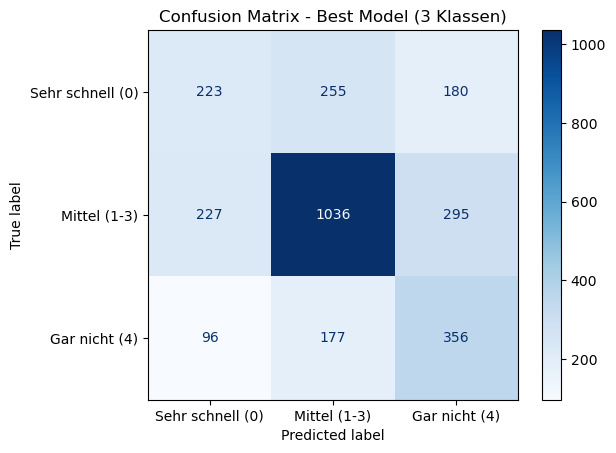


Top 10 Konfigurationen:
F1: 0.5341±0.008 | max_depth=15, lr=0.030, subsample=0.6
F1: 0.5338±0.007 | max_depth=15, lr=0.030, subsample=0.8
F1: 0.5337±0.008 | max_depth=15, lr=0.050, subsample=0.7
F1: 0.5328±0.009 | max_depth=11, lr=0.050, subsample=0.8
F1: 0.5322±0.014 | max_depth=15, lr=0.070, subsample=0.7
F1: 0.5310±0.013 | max_depth=15, lr=0.070, subsample=0.9
F1: 0.5307±0.007 | max_depth=15, lr=0.050, subsample=0.8
F1: 0.5301±0.011 | max_depth=15, lr=0.010, subsample=0.6
F1: 0.5299±0.008 | max_depth=11, lr=0.050, subsample=0.6
F1: 0.5298±0.012 | max_depth=15, lr=0.100, subsample=0.8

Klassen-Verteilung im Test Set:
Klasse 0 (Sehr schnell (0)): 658 Samples
Klasse 1 (Mittel (1-3)): 1558 Samples
Klasse 2 (Gar nicht (4)): 629 Samples


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

# Daten laden (bereits preprocessed)
print("Lade vorverarbeitete Daten...")

X_train_res = pd.read_csv("Data/preprocessed/X_train_res.csv")
y_train_res = pd.read_csv("Data/preprocessed/y_train_res.csv").iloc[:, 0]

X_valid = pd.read_csv("Data/preprocessed/X_valid_enc.csv")
y_valid = pd.read_csv("Data/preprocessed/y_valid.csv").iloc[:, 0]

X_test = pd.read_csv("Data/preprocessed/X_test_enc.csv")
y_test = pd.read_csv("Data/preprocessed/y_test.csv").iloc[:, 0]

print(f"Training Set (oversampled): {X_train_res.shape}")
print(f"Validation Set: {X_valid.shape}")
print(f"Test Set: {X_test.shape}")

print("Train classes:", np.unique(y_train_res))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))
print(f"Class distribution in training: {np.bincount(y_train_res)}")

# HYPOTHESE 4: max_depth × learning_rate × subsample
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 15],
    'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01], 
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
}

total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

def evaluate_params_native(max_depth, learning_rate, subsample, X_train, y_train):
    """Evaluiert Parameter mit nativem XGBoost (ohne sklearn)"""
    
    # Manual 6-Fold Cross Validation
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_tr, label=y_tr)
        dval_fold = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'random_state': 42,
            'verbosity': 0
        }
        
        # Train model
        model = xgb.train(params, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        # Predict and calculate F1
        y_pred = model.predict(dval_fold)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }

# Kombiniere Training + Validation für Cross-Validation
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

print("Starte Native XGBoost Grid Search...")
start_time = time.time()

results = []
for i, (max_depth, learning_rate, subsample) in enumerate(
    product(param_grid['max_depth'], 
            param_grid['learning_rate'], 
            param_grid['subsample']), 1):
    
    print(f"[{i:3d}/{total_combinations}] max_depth={max_depth:2d}, lr={learning_rate:.3f}, subsample={subsample:.1f}", end=" ")
    
    result = evaluate_params_native(max_depth, learning_rate, subsample, X_train_val, y_train_val)
    results.append(result)
    
    print(f"→ F1: {result['f1_mean']:.4f}±{result['f1_std']:.3f}")

total_time = time.time() - start_time

# Ergebnisse analysieren
results_df = pd.DataFrame(results)

print(f"\nNative XGBoost Grid Search abgeschlossen in {total_time/60:.1f} Minuten")

# Beste Konfiguration finden
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print(f"Best parameters: {{'max_depth': {best_result['max_depth']}, 'learning_rate': {best_result['learning_rate']:.3f}, 'subsample': {best_result['subsample']:.1f}}}")
print(f"Best CV score: {best_result['f1_mean']:.4f}")

# Bestes Modell auf Test Set evaluieren (native XGBoost)
dtrain_final = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'max_depth': int(best_result['max_depth']),
    'learning_rate': best_result['learning_rate'],
    'subsample': best_result['subsample'],
    'random_state': 42,
    'verbosity': 0
}

best_model = xgb.train(best_params, dtrain_final, num_boost_round=100, verbose_eval=False)
y_test_pred = best_model.predict(dtest)

# Test Metriken
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (für 3 Klassen)
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_test_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Model (3 Klassen)")
plt.show()

# Top 10 Konfigurationen
print(f"\nTop 10 Konfigurationen:")
print("="*90)
top_10 = results_df.nlargest(10, 'f1_mean')

for idx, row in top_10.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"max_depth={int(row['max_depth']):2d}, lr={row['learning_rate']:.3f}, subsample={row['subsample']:.1f}")

# Klassen-Verteilung anzeigen
print(f"\nKlassen-Verteilung im Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    class_names = ["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"]
    print(f"Klasse {cls} ({class_names[cls]}): {count} Samples")

# 10 Fold

Lade vorverarbeitete Daten...
Training Set (oversampled): (8814, 21)
Validation Set: (2845, 21)
Test Set: (2845, 21)
Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Class distribution in training: [2938 2938 2938]
Teste 180 Parameterkombinationen
Starte Native XGBoost Grid Search...
[  1/180] max_depth= 3, lr=0.100, subsample=1.0 → F1: 0.4795±0.012
[  2/180] max_depth= 3, lr=0.100, subsample=0.9 → F1: 0.4832±0.015
[  3/180] max_depth= 3, lr=0.100, subsample=0.8 → F1: 0.4829±0.012
[  4/180] max_depth= 3, lr=0.100, subsample=0.7 → F1: 0.4818±0.014
[  5/180] max_depth= 3, lr=0.100, subsample=0.6 → F1: 0.4825±0.009
[  6/180] max_depth= 3, lr=0.100, subsample=0.5 → F1: 0.4822±0.011
[  7/180] max_depth= 3, lr=0.070, subsample=1.0 → F1: 0.4742±0.013
[  8/180] max_depth= 3, lr=0.070, subsample=0.9 → F1: 0.4763±0.012
[  9/180] max_depth= 3, lr=0.070, subsample=0.8 → F1: 0.4763±0.014
[ 10/180] max_depth= 3, lr=0.070, subsample=0.7 → F1: 0.4793±0.013
[ 11/180] max_depth= 3, lr

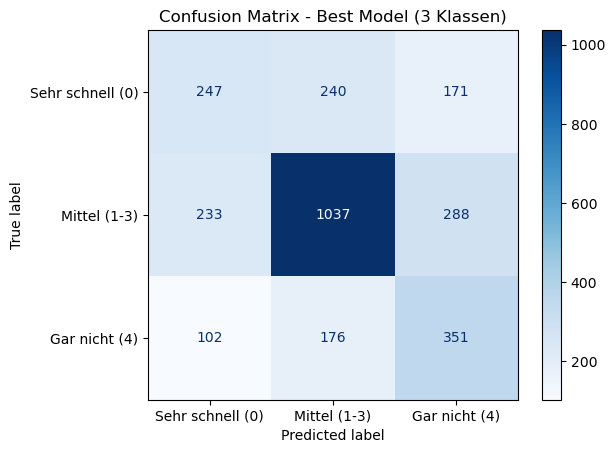


Top 10 Konfigurationen:
F1: 0.5352±0.010 | max_depth=15, lr=0.050, subsample=0.6
F1: 0.5333±0.013 | max_depth=15, lr=0.070, subsample=0.9
F1: 0.5330±0.013 | max_depth=15, lr=0.050, subsample=0.9
F1: 0.5328±0.015 | max_depth=11, lr=0.100, subsample=0.9
F1: 0.5326±0.017 | max_depth=11, lr=0.050, subsample=0.9
F1: 0.5324±0.011 | max_depth=15, lr=0.030, subsample=0.6
F1: 0.5323±0.015 | max_depth=15, lr=0.050, subsample=0.8
F1: 0.5322±0.013 | max_depth=15, lr=0.070, subsample=0.7
F1: 0.5322±0.013 | max_depth=11, lr=0.050, subsample=0.8
F1: 0.5320±0.018 | max_depth=11, lr=0.070, subsample=0.9

Klassen-Verteilung im Test Set:
Klasse 0 (Sehr schnell (0)): 658 Samples
Klasse 1 (Mittel (1-3)): 1558 Samples
Klasse 2 (Gar nicht (4)): 629 Samples


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

# Daten laden (bereits preprocessed)
print("Lade vorverarbeitete Daten...")

X_train_res = pd.read_csv("Data/preprocessed/X_train_res.csv")
y_train_res = pd.read_csv("Data/preprocessed/y_train_res.csv").iloc[:, 0]

X_valid = pd.read_csv("Data/preprocessed/X_valid_enc.csv")
y_valid = pd.read_csv("Data/preprocessed/y_valid.csv").iloc[:, 0]

X_test = pd.read_csv("Data/preprocessed/X_test_enc.csv")
y_test = pd.read_csv("Data/preprocessed/y_test.csv").iloc[:, 0]

print(f"Training Set (oversampled): {X_train_res.shape}")
print(f"Validation Set: {X_valid.shape}")
print(f"Test Set: {X_test.shape}")

print("Train classes:", np.unique(y_train_res))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))
print(f"Class distribution in training: {np.bincount(y_train_res)}")

# HYPOTHESE 4: max_depth × learning_rate × subsample
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 15],
    'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01], 
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
}

total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

def evaluate_params_native(max_depth, learning_rate, subsample, X_train, y_train):
    """Evaluiert Parameter mit nativem XGBoost (ohne sklearn)"""
    
    # Manual 10-Fold Cross Validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_tr, label=y_tr)
        dval_fold = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'random_state': 42,
            'verbosity': 0
        }
        
        # Train model
        model = xgb.train(params, dtrain_fold, num_boost_round=100, verbose_eval=False)
        
        # Predict and calculate F1
        y_pred = model.predict(dval_fold)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }

# Kombiniere Training + Validation für Cross-Validation
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

print("Starte Native XGBoost Grid Search...")
start_time = time.time()

results = []
for i, (max_depth, learning_rate, subsample) in enumerate(
    product(param_grid['max_depth'], 
            param_grid['learning_rate'], 
            param_grid['subsample']), 1):
    
    print(f"[{i:3d}/{total_combinations}] max_depth={max_depth:2d}, lr={learning_rate:.3f}, subsample={subsample:.1f}", end=" ")
    
    result = evaluate_params_native(max_depth, learning_rate, subsample, X_train_val, y_train_val)
    results.append(result)
    
    print(f"→ F1: {result['f1_mean']:.4f}±{result['f1_std']:.3f}")

total_time = time.time() - start_time

# Ergebnisse analysieren
results_df = pd.DataFrame(results)

print(f"\nNative XGBoost Grid Search abgeschlossen in {total_time/60:.1f} Minuten")

# Beste Konfiguration finden
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print(f"Best parameters: {{'max_depth': {best_result['max_depth']}, 'learning_rate': {best_result['learning_rate']:.3f}, 'subsample': {best_result['subsample']:.1f}}}")
print(f"Best CV score: {best_result['f1_mean']:.4f}")

# Bestes Modell auf Test Set evaluieren (native XGBoost)
dtrain_final = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'max_depth': int(best_result['max_depth']),
    'learning_rate': best_result['learning_rate'],
    'subsample': best_result['subsample'],
    'random_state': 42,
    'verbosity': 0
}

best_model = xgb.train(best_params, dtrain_final, num_boost_round=100, verbose_eval=False)
y_test_pred = best_model.predict(dtest)

# Test Metriken
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (für 3 Klassen)
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_test_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Model (3 Klassen)")
plt.show()

# Top 10 Konfigurationen
print(f"\nTop 10 Konfigurationen:")
print("="*90)
top_10 = results_df.nlargest(10, 'f1_mean')

for idx, row in top_10.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"max_depth={int(row['max_depth']):2d}, lr={row['learning_rate']:.3f}, subsample={row['subsample']:.1f}")

# Klassen-Verteilung anzeigen
print(f"\nKlassen-Verteilung im Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    class_names = ["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"]
    print(f"Klasse {cls} ({class_names[cls]}): {count} Samples")

# Hypothese 5

## Hypothese 5 pre oversamling

### 3 Fold

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

# Daten laden
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

df['target'] = df['AdoptionSpeed']

# Features & Labels trennen
X = df.drop(columns=['AdoptionSpeed', 'target'])
y = df['target'].astype(int)

# Stratified Split: Train / Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Stratified Split: Temp → Valid / Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train classes:", np.unique(y_train))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# Kategorische Variablen in Kategorie-Typ umwandeln
for df_ in [X_train, X_valid, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# Oversampling nur auf Train
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape}")
print(f"Oversampled Training Set: {X_train_res.shape}")
print(f"Class distribution after oversampling: {np.bincount(y_train_res)}")

# Kategorische Spalten encodieren
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    X_test[cat_cols] = oe.transform(X_test[cat_cols])

print(f"Final Training Set: {X_train_res.shape}, Validation Set: {X_valid.shape}, Test Set: {X_test.shape}")

# Neue Grid: n_estimators × max_depth × subsample
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 600, 800, 1000],    # 6 Werte
    'max_depth': [7, 9, 11,15, 18, 21],                # 6 Werte  
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]       # 6 Werte
}

total_combinations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

# Neue Bewertungsfunktion
def evaluate_params_native(n_estimators, max_depth, subsample, X_train, y_train, num_classes):
    """Evaluiert Parameter mit nativem XGBoost (ohne sklearn)"""
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain_fold = xgb.DMatrix(X_tr, label=y_tr)
        dval_fold = xgb.DMatrix(X_val, label=y_val)

        params = {
            'objective': 'multi:softmax',
            'num_class': num_classes,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'subsample': subsample,
            'random_state': 42,
            'verbosity': 0
        }

        model = xgb.train(params, dtrain_fold, num_boost_round=n_estimators, verbose_eval=False)

        y_pred = model.predict(dval_fold)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

    return {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }

# Training + Validation kombinieren
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

# Anzahl Klassen
num_classes = len(np.unique(y))
print(f"Using num_classes = {num_classes} for XGBoost")

# Grid Search starten
print("Starte Native XGBoost Grid Search (n_estimators × max_depth × subsample)...")
start_time = time.time()

results = []
for i, (n_estimators, max_depth, subsample) in enumerate(
    product(param_grid['n_estimators'], 
            param_grid['max_depth'], 
            param_grid['subsample']), 1):
    
    print(f"[{i:3d}/{total_combinations}] n_estimators={n_estimators:3d}, max_depth={max_depth:2d}, subsample={subsample:.1f}", end=" ")
    
    result = evaluate_params_native(n_estimators, max_depth, subsample, X_train_val, y_train_val, num_classes)
    results.append(result)
    
    print(f"→ F1: {result['f1_mean']:.4f}±{result['f1_std']:.3f}")

total_time = time.time() - start_time
results_df = pd.DataFrame(results)

print(f"\nNative XGBoost Grid Search abgeschlossen in {total_time/60:.1f} Minuten")

# Beste Konfiguration
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print(f"Best parameters: {{'n_estimators': {best_result['n_estimators']}, 'max_depth': {best_result['max_depth']}, 'subsample': {best_result['subsample']:.1f}}}")
print(f"Best CV score: {best_result['f1_mean']:.4f}")

# Modell auf Test Set evaluieren
dtrain_final = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'multi:softmax',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'max_depth': int(best_result['max_depth']),
    'subsample': best_result['subsample'],
    'random_state': 42,
    'verbosity': 0
}

best_model = xgb.train(best_params, dtrain_final, num_boost_round=int(best_result['n_estimators']), verbose_eval=False)
y_test_pred = best_model.predict(dtest)

# Test-Metriken
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix anzeigen
unique_classes = sorted(np.unique(y))
if num_classes == 5:
    class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]
elif num_classes == 3:
    class_labels = ["Sehr schnell (0)", "Mittel (1-3)", "Gar nicht (4)"]
else:
    class_labels = [f"Class {i}" for i in unique_classes]

cm = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Best Model ({num_classes} Klassen)")
plt.tight_layout()
plt.show()

# Top 10 Ergebnisse
print(f"\nTop 10 Konfigurationen:")
print("="*90)
top_10 = results_df.nlargest(10, 'f1_mean')

for idx, row in top_10.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"n_estimators={int(row['n_estimators'])}, max_depth={int(row['max_depth'])}, subsample={row['subsample']:.1f}")

# Klassenverteilung Test-Set
print(f"\nKlassen-Verteilung im Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Klasse {cls}: {count} Samples")


Train classes: [0 1 2 3 4]
Valid classes: [0 1 2 3 4]
Test classes: [0 1 2 3 4]
Original Training Set: (13275, 22)
Oversampled Training Set: (15335, 22)
Class distribution after oversampling: [3067 3067 3067 3067 3067]
Final Training Set: (15335, 22), Validation Set: (2845, 22), Test Set: (2845, 22)
Teste 288 Parameterkombinationen
Using num_classes = 5 for XGBoost
Starte Native XGBoost Grid Search (n_estimators × max_depth × subsample)...
[  1/288] n_estimators= 50, max_depth= 7, subsample=1.0 → F1: 0.4563±0.006
[  2/288] n_estimators= 50, max_depth= 7, subsample=0.9 → F1: 0.4626±0.005
[  3/288] n_estimators= 50, max_depth= 7, subsample=0.8 → F1: 0.4593±0.003
[  4/288] n_estimators= 50, max_depth= 7, subsample=0.7 → F1: 0.4542±0.004
[  5/288] n_estimators= 50, max_depth= 7, subsample=0.6 → F1: 0.4432±0.002
[  6/288] n_estimators= 50, max_depth= 7, subsample=0.5 → F1: 0.4404±0.001
[  7/288] n_estimators= 50, max_depth= 9, subsample=1.0 → F1: 0.4852±0.007
[  8/288] n_estimators= 50, max

: 

## Hypothese 5 post oversamling

### 3 Fold

Unique classes in training: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Unique classes in test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Number of classes: 5
Train classes: [0 1 2 3 4]
Valid classes: [0 1 2 3 4]
Test classes: [0 1 2 3 4]
X_train columns: 22
X_valid columns: 22
X_test columns: 21
Common columns: 21
Original Training Set: (10620, 21)
Oversampled Training Set: (12295, 21)
Class distribution after oversampling: [2459 2459 2459 2459 2459]
Categorical columns to encode: []
No categorical columns found for encoding
Final Training Set: (12295, 21), Validation Set: (2655, 21), Test Set: (2845, 21)
HYPOTHESE 5: n_estimators × max_depth × subsample
Kernthese: 'Große Ensembles mit tiefen Bäumen benötigen stärkere Regularisierung'
Erwartung: Bei n_estimators↑ UND max_depth↑ → subsample↓
Teste 216 Parameterkombinationen
Using num_classes = 5 for XGBoost
Starte Native XGBoost Grid Search für Hypothese 5...
[  1/216] n_est= 50, max_depth=

KeyboardInterrupt: 